In [35]:
import numpy as np
import cv2
import time
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC
import sklearn.svm as svm
from skimage.feature import hog
%matplotlib inline

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    return hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')

In [5]:
def get_training_files():
    # Read in cars and notcars
    cars = glob.glob('data/vehicles/**/*.png')
    notcars = glob.glob('data/non-vehicles/**/*.png')
    return cars, notcars

In [6]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            if feature_image.max() <= 1:
                hist_features = color_hist(feature_image * 255, nbins=hist_bins)
            else:
                hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

Training set sizes:
Vehicle: 8792
Non-vehicle: 8968


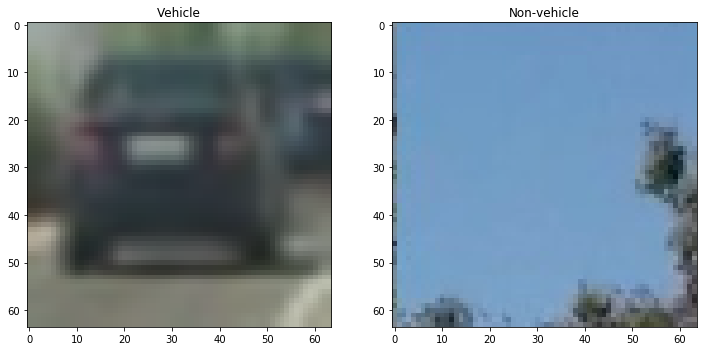

In [7]:
# Visualizing images from data set
cars, notcars = get_training_files()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(mpimg.imread(cars[0]))
ax1.set_title('Vehicle')
ax2.imshow(mpimg.imread(notcars[0]))
ax2.set_title('Non-vehicle')

print('Training set sizes:')
print('Vehicle:', len(cars))
print('Non-vehicle:', len(notcars))

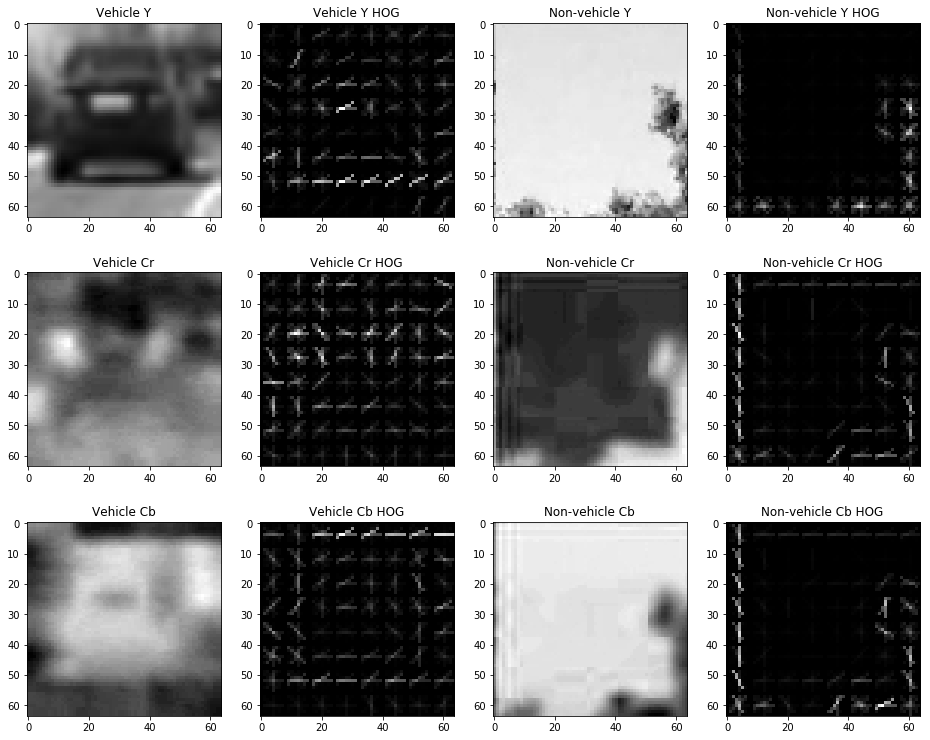

In [164]:
# HOG visualization
cars, notcars = get_training_files()
car = mpimg.imread(cars[0])
notcar = mpimg.imread(notcars[0])

fig, ax = plt.subplots(3, 4, figsize=(16, 13)) 

for index, (img, title) in enumerate(zip([car, notcar], ['Vehicle', 'Non-vehicle'])):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    for (component, channel_name) in zip(range(img.shape[-1]), ['Y', 'Cr', 'Cb']):
        gray = img[:,:,component]
        _, hog_image = get_hog_features(gray, orient=8, pix_per_cell=8, cell_per_block=2, vis=True)
        ax[component, index * 2].imshow(gray, cmap='gray')
        ax[component, index * 2].set_title('%s %s' % (title, channel_name))
        ax[component, index * 2 + 1].imshow(hog_image, cmap='gray')
        ax[component, index * 2 + 1].set_title('%s %s HOG' % (title, channel_name))

In [8]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cells_per_step, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
             spatial_feat=True, hist_feat=True, hog_feat=True):
    
    rectangles = []
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    if hog_feat:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            if hog_feat:
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = np.empty(shape=(0,))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            if spatial_feat or hist_feat:
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size) if spatial_feat else np.empty(shape=(0,))
            hist_features = color_hist(subimg, nbins=hist_bins) if hist_feat else np.empty(shape=(0,))
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [182]:
# Testing color spaces for HOG
cars, notcars = get_training_files()
#cars = cars[:1000]
#notcars = notcars[:1000]
color_spaces = ['RGB', 'HSV', 'HLS', 'YUV', 'YCrCb']
using_component = [0, 1, 2, 'ALL']

for color_space in color_spaces:
    for component in using_component:
        car_features = extract_features(cars, color_space=color_space, hog_channel=component, spatial_feat=False, hist_feat=False)
        notcar_features = extract_features(notcars, color_space=color_space, hog_channel=component, spatial_feat=False, hist_feat=False)
        
        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)
        
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
        
        X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)
        
        svc = LinearSVC()
        svc.fit(X_train, y_train)
        print('Color space %s, using %s component, test accuracy is %0.4f' % 
              (color_space, str(component), svc.score(X_test, y_test)))

Color space RGB, using 0 component, test accuracy is 0.9048
Color space RGB, using 1 component, test accuracy is 0.9181
Color space RGB, using 2 component, test accuracy is 0.9167
Color space RGB, using ALL component, test accuracy is 0.9245
Color space HSV, using 0 component, test accuracy is 0.8986
Color space HSV, using 1 component, test accuracy is 0.9029
Color space HSV, using 2 component, test accuracy is 0.9198
Color space HSV, using ALL component, test accuracy is 0.9589
Color space HLS, using 0 component, test accuracy is 0.8998
Color space HLS, using 1 component, test accuracy is 0.9108
Color space HLS, using 2 component, test accuracy is 0.8899
Color space HLS, using ALL component, test accuracy is 0.9521
Color space YUV, using 0 component, test accuracy is 0.9105
Color space YUV, using 1 component, test accuracy is 0.9009
Color space YUV, using 2 component, test accuracy is 0.9220
Color space YUV, using ALL component, test accuracy is 0.9645
Color space YCrCb, using 0 compo

In [183]:
for orientations in range(6, 12 + 1):
    car_features = extract_features(cars, orient=orientations, color_space='YCrCb', hog_channel='ALL', spatial_feat=False, hist_feat=False)
    notcar_features = extract_features(notcars, orient=orientations, color_space='YCrCb', hog_channel='ALL', spatial_feat=False, hist_feat=False)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)

    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

    svc = LinearSVC()
    svc.fit(X_train, y_train)
    print('Number of orientations %d, feature vector size %d, test accuracy is %0.4f' % 
          (orientations, X.shape[-1], svc.score(X_test, y_test)))

Number of orientations 6, feature vector size 3528, test accuracy is 0.9662
Number of orientations 7, feature vector size 4116, test accuracy is 0.9651
Number of orientations 8, feature vector size 4704, test accuracy is 0.9665
Number of orientations 9, feature vector size 5292, test accuracy is 0.9637
Number of orientations 10, feature vector size 5880, test accuracy is 0.9642
Number of orientations 11, feature vector size 6468, test accuracy is 0.9620
Number of orientations 12, feature vector size 7056, test accuracy is 0.9609


In [6]:
cars, notcars = get_training_files()

for pix_per_cell in [8, 16]:
    for cells_per_block in [2, 3, 4]:
        car_features = extract_features(cars, pix_per_cell=pix_per_cell, cell_per_block=cells_per_block, orient=6, color_space='YCrCb', hog_channel='ALL', spatial_feat=False, hist_feat=False)
        notcar_features = extract_features(notcars, pix_per_cell=pix_per_cell, cell_per_block=cells_per_block, orient=6, color_space='YCrCb', hog_channel='ALL', spatial_feat=False, hist_feat=False)

        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        X_scaler = StandardScaler().fit(X)
        scaled_X = X_scaler.transform(X)

        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

        svc = LinearSVC()
        svc.fit(X_train, y_train)
        print('Pix per cell %d, cells per block %d, feature vector size %d, test accuracy is %0.4f' % 
              (pix_per_cell, cells_per_block, X.shape[-1], svc.score(X_test, y_test)))

Pix per cell 8, cells per block 2, feature vector size 3528, test accuracy is 0.9659
Pix per cell 8, cells per block 3, feature vector size 5832, test accuracy is 0.9707
Pix per cell 8, cells per block 4, feature vector size 7200, test accuracy is 0.9713
Pix per cell 16, cells per block 2, feature vector size 648, test accuracy is 0.9758
Pix per cell 16, cells per block 3, feature vector size 648, test accuracy is 0.9786
Pix per cell 16, cells per block 4, feature vector size 288, test accuracy is 0.9747


In [11]:
cars, notcars = get_training_files()

for spatial_size in [12, 16, 24, 32, 48]:
    car_features = extract_features(cars, spatial_size=(spatial_size, spatial_size), color_space='YCrCb', hog_feat=False, hist_feat=False)
    notcar_features = extract_features(notcars, spatial_size=(spatial_size, spatial_size), color_space='YCrCb', hog_feat=False, hist_feat=False)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)

    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

    svc = LinearSVC()
    svc.fit(X_train, y_train)
    print('Spatial size %d, feature vector size %d, test accuracy is %0.4f' % 
          (spatial_size, X.shape[-1], svc.score(X_test, y_test)))

Spatial size 12, feature vector size 432, test accuracy is 0.9169
Spatial size 16, feature vector size 768, test accuracy is 0.9234
Spatial size 24, feature vector size 1728, test accuracy is 0.8992
Spatial size 32, feature vector size 3072, test accuracy is 0.8986
Spatial size 48, feature vector size 6912, test accuracy is 0.8998


In [23]:
cars, notcars = get_training_files()

for hist_bins in [12, 16, 24, 32, 48, 64, 96, 128, 192, 256]:
    car_features = extract_features(cars, hist_bins=hist_bins, color_space='YCrCb', hog_feat=False, spatial_feat=False)
    notcar_features = extract_features(notcars, hist_bins=hist_bins, color_space='YCrCb', hog_feat=False, spatial_feat=False)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)

    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

    svc = LinearSVC()
    svc.fit(X_train, y_train)
    print('Hist bins %d, feature vector size %d, test accuracy is %0.4f' % 
          (hist_bins, X.shape[-1], svc.score(X_test, y_test)))

Hist bins 12, feature vector size 36, test accuracy is 0.8716
Hist bins 16, feature vector size 48, test accuracy is 0.8871
Hist bins 24, feature vector size 72, test accuracy is 0.9113
Hist bins 32, feature vector size 96, test accuracy is 0.9223
Hist bins 48, feature vector size 144, test accuracy is 0.9268
Hist bins 64, feature vector size 192, test accuracy is 0.9307
Hist bins 96, feature vector size 288, test accuracy is 0.9437
Hist bins 128, feature vector size 384, test accuracy is 0.9398
Hist bins 192, feature vector size 576, test accuracy is 0.9423
Hist bins 256, feature vector size 768, test accuracy is 0.9403


In [5]:
# Prepare all features
cars, notcars = get_training_files()
car_features = extract_features(cars, spatial_size=(16, 16), hist_bins=96, orient=6, pix_per_cell=16, cell_per_block=3, color_space='YCrCb', hog_channel='ALL')
notcar_features = extract_features(notcars, spatial_size=(16, 16), hist_bins=96, orient=6, pix_per_cell=16, cell_per_block=3, color_space='YCrCb', hog_channel='ALL')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

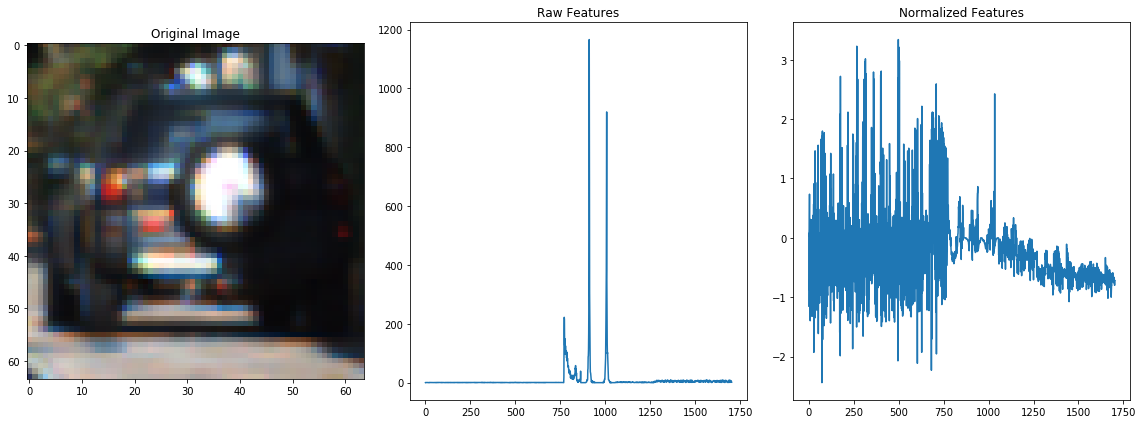

In [27]:
car_ind = np.random.randint(0, len(car_features))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(16,6))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

In [11]:
# Identifying the best parameters for SVC with RBF kernel
Cs = [0.1, 1, 10, 100, 1000]
gammas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid)
grid_search.fit(X_train[:500], y_train[:500])
print(grid_search.best_params_)

{'C': 100, 'gamma': 1e-05}


In [35]:
# Identifying the best parameters for linear SVC
Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'C': Cs}
grid_search = GridSearchCV(LinearSVC(), param_grid)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'C': 0.01}


In [36]:
# Compare test scores for linear and RBF classifiers
clf_rbf = svm.SVC(kernel='rbf', C=100, gamma=0.00001)
clf_linear = LinearSVC(C=0.01)

clf_rbf.fit(X_train, y_train)

t=time.time()
print('RBF test score is %.04f' % clf_rbf.score(X_test, y_test))
t2 = time.time()
print('Calculated in %0.02f seconds' % (t2-t))

clf_linear.fit(X_train, y_train)

t=time.time()
print('Linear test score is %.04f' % clf_linear.score(X_test, y_test))
t2 = time.time()
print('Calculated in %0.02f seconds' % (t2-t))

RBF test score is 0.9910
Calculated in 6.21 seconds
Linear test score is 0.9910
Calculated in 0.01 seconds


In [41]:
# Resrt globals
color_space = 'YCrCb'

start_stop_scale = [
        (400, 480, 1),
        (400, 560, 1.5),
        (400, 640, 2)
]

pipeline_clf = None
pipeline_scaler = None

pipeline_hog = None
pipeline_spatial = None
pipeline_hist = None

pipeline_hist_bins = None
pipeline_spatial_size = None
# HOG PARAMS
pipeline_orient = None
pipeline_pix_per_cell = None
pipeline_cell_per_block = None

pipeline_cells_per_step = None

In [87]:
# Sliding windows pipeline
last_rectangles = None
rectangles_history = []

# Restart pipeline just restarts rectangles history
def restart_pipeline(group_frames=6, threshold=2):
    global last_rectangles
    global rectangles_history
    
    global pipeline_group_frames
    global pipeline_threshold
    
    last_rectangle = None
    rectangles_history = []
    
    pipeline_group_frames = group_frames
    pipeline_threshold = threshold

# And reset pipeline re-calculates features and retrains classifier
def reset_pipeline(hog_feat=True, spatial_feat=True, hist_feat=True, hist_bins=96, spatial_size=(16,16),
                  orient=6, pix_per_cell=16, cell_per_block=3, cells_per_step=1):
    global pipeline_clf
    global pipeline_scaler
    global pipeline_hog
    global pipeline_spatial
    global pipeline_hist
    global pipeline_hist_bins
    global pipeline_spatial_size
    
    global pipeline_orient
    global pipeline_pix_per_cell
    global pipeline_cell_per_block
    
    global pipeline_cells_per_step
    
    global last_rectangles
    global rectangles_history
    
    pipeline_hog = hog_feat
    pipeline_spatial = spatial_feat
    pipeline_hist = hist_feat
    
    pipeline_orient = orient
    pipeline_pix_per_cell = pix_per_cell
    pipeline_cell_per_block = cell_per_block
    
    pipeline_cells_per_step = cells_per_step
    
    pipeline_hist_bins = hist_bins
    pipeline_spatial_size = spatial_size
    
    cars, notcars = get_training_files()
    print('Extracting vehicle features')
    car_features = extract_features(cars, spatial_size=pipeline_spatial_size, hist_bins=pipeline_hist_bins, 
                                    orient=pipeline_orient, pix_per_cell=pipeline_pix_per_cell, cell_per_block=pipeline_cell_per_block, 
                                    color_space=color_space, hog_channel='ALL',
                                    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    print('Extracting non-vehicle features')
    notcar_features = extract_features(notcars, spatial_size=pipeline_spatial_size, hist_bins=pipeline_hist_bins, 
                                    orient=pipeline_orient, pix_per_cell=pipeline_pix_per_cell, cell_per_block=pipeline_cell_per_block, 
                                    color_space=color_space, hog_channel='ALL',
                                    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    pipeline_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = pipeline_scaler.transform(X)

    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    print('Fitting classifier')
    pipeline_clf = LinearSVC(C=0.01)
    pipeline_clf.fit(scaled_X, y)
    print('Pipeline reset done')
    restart_pipeline()
    
# Join overlapping rectangles using heatmap method
def join_rectangles(img, rectangles_set, return_heatmap=False, threshold=2):
    
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    for rectangles in rectangles_set:
        for box in rectangles:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
            
    heatmap[heatmap <= threshold] = 0
    labels = label(heatmap)
    
    joined_rectangles = []
    
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        joined_rectangles.append(bbox)
        
    if return_heatmap:
        return joined_rectangles, heatmap
    else:
        return joined_rectangles

# True if point is inside the rect
def is_point_inside_rect(rect, point):
    return (rect[0][0] <= point[0] <= rect[1][0] and
        rect[0][1] <= point[1] <= rect[1][1])

# Returns rect center
def get_rect_center(rect):
    return ((rect[0][0] + rect[1][0]) / 2), ((rect[0][1] + rect[1][1]) / 2)

# Finds 'similar' rect from the list of rects
def find_similar_rect(from_rects, to_rect):
    to_rect_center = get_rect_center(to_rect)
    for rect in from_rects:
        rect_center = get_rect_center(rect)
        if is_point_inside_rect(to_rect, rect_center) or is_point_inside_rect(rect, to_rect_center):
            return rect
        
    return None

def smooth_transition(k1, k2, a=.1):
    return int(k2 * a + (1 - a) * k1)
    
# This method analyzes last and current rectangles and applies exponential smoothing to avoid jittering
def smooth_rectangles(last_rects, new_rects):
    if new_rects is None:
        return None
    
    if last_rects is None:
        return new_rects
    
    smoothed = []
    for rect in new_rects:
        similar_rect = find_similar_rect(last_rects, rect)
        if similar_rect is not None:
            smoothed.append(((smooth_transition(similar_rect[0][0], rect[0][0]),
                              smooth_transition(similar_rect[0][1], rect[0][1])),
                             (smooth_transition(similar_rect[1][0], rect[1][0]),
                              smooth_transition(similar_rect[1][1], rect[1][1]))))
        else:
            smoothed.append(rect)
        
    return smoothed


# Image processing pipeline for recognition with joining overlapping rectangles    
def process_image_joined(img):
    
    global last_rectangles
    global rectangles_history
    
    global pipeline_group_frames
    global pipeline_threshold
    
    rectangles = process_image(img, return_rectangles=True)
    
    rectangles_history.append(rectangles)
    
    joined_rectangles = None
    
    if len(rectangles_history) >= pipeline_group_frames:
        rectangles_history = rectangles_history[-pipeline_group_frames:]
        joined_rectangles = join_rectangles(img, rectangles_history, threshold=pipeline_threshold)
        
    joined_rectangles = smooth_rectangles(last_rectangles, joined_rectangles)
    
    last_rectangles = joined_rectangles
    
    draw_img = np.copy(img)
    if joined_rectangles is not None:
        for point_from, point_to in joined_rectangles:
            cv2.rectangle(draw_img, point_from, point_to, (0,0,255), 6)
    
    return draw_img
    

# Image processing pipeline for recognition without joining overlapping rectangles
def process_image(img, return_rectangles=False):
    global pipeline_clf
    global pipeline_scaler
    global pipeline_hog
    global pipeline_spatial
    global pipeline_hist
    
    global pipeline_hist_bins
    global pipeline_spatial_size
    
    global pipeline_orient
    global pipeline_pix_per_cell
    global pipeline_cell_per_block
    
    global pipeline_cells_per_step
    
    if pipeline_clf is None:
        print('Please call reset_pipeline() first')
        return None
    
    rectangles = []

    for (ystart, ystop, scale) in start_stop_scale:
        rectangles.extend(find_cars(img, ystart, ystop, scale, pipeline_cells_per_step, 
                                    pipeline_clf, pipeline_scaler, 'RGB2' + color_space, pipeline_orient, 
                                    pipeline_pix_per_cell, pipeline_cell_per_block, pipeline_spatial_size, pipeline_hist_bins,
                                   spatial_feat=pipeline_spatial, hist_feat=pipeline_hist, hog_feat=pipeline_hog))
        
    draw_img = np.copy(img)

    for point_from, point_to in rectangles:
        cv2.rectangle(draw_img, point_from, point_to, (0,0,255), 6)
        
    if return_rectangles:
        return rectangles
    else:
        return draw_img

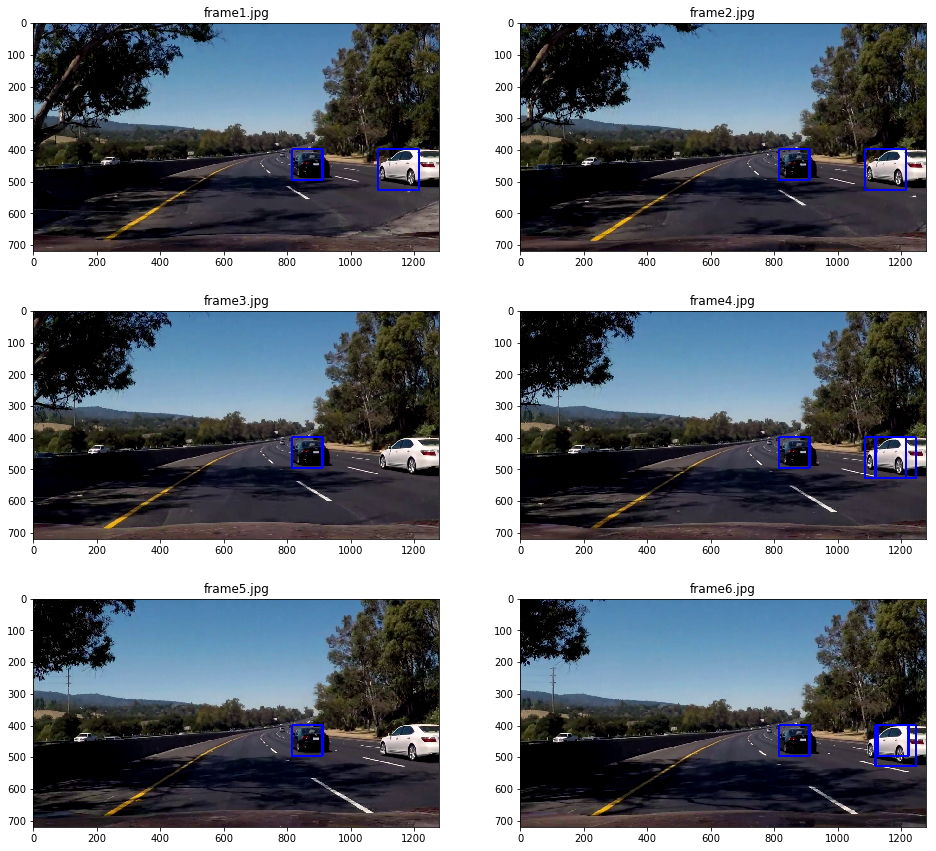

In [34]:
fig, ax = plt.subplots(3, 2, figsize=(16, 15))

#reset_pipeline()

for index, file_name in enumerate(glob.glob('test_images/frame*')[:6]):
    img = mpimg.imread(file_name)
 
    image = process_image(img)
    if image is None:
        break
    ax[index // 2, index % 2].imshow(image)
    ax[index // 2, index % 2].set_title(file_name[-10:])

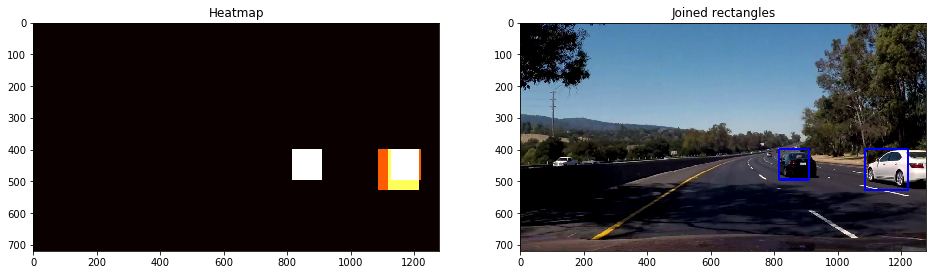

In [47]:
rectangles_set = []

#reset_pipeline()

for index, file_name in enumerate(glob.glob('test_images/frame*')[:6]):
    img = mpimg.imread(file_name)
 
    rectangles_set.append(process_image(img, return_rectangles=True))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
joined_rectangles, heatmap = join_rectangles(img, rectangles_set, return_heatmap=True)
ax1.imshow(heatmap, cmap='hot')
ax1.set_title('Heatmap')

draw_img = np.copy(img)

for point_from, point_to in joined_rectangles:
    cv2.rectangle(draw_img, point_from, point_to, (0,0,255), 6)
    
ax2.imshow(draw_img)
ax2.set_title('Joined rectangles')

In [103]:
from moviepy.editor import VideoFileClip
import os

#reset_pipeline()
reset_pipeline(hog_feat=True, spatial_feat=True, hist_feat=True, spatial_size=(48, 48))
#               pix_per_cell=8, cell_per_block=2, hist_bins=32, cells_per_step=2)
os.makedirs('test_videos_output', exist_ok=True)
output = 'test_videos_output/project_video_48.mp4'
clip = VideoFileClip('project_video.mp4')
clip_processed = clip.fl_image(process_image)
%time clip_processed.write_videofile(output, audio=False)

Extracting vehicle features
Extracting non-vehicle features
Fitting classifier
Pipeline reset done
[MoviePy] >>>> Building video test_videos_output/project_video_48.mp4
[MoviePy] Writing video test_videos_output/project_video_48.mp4


100%|█████████▉| 1260/1261 [09:11<00:00,  2.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_48.mp4 

CPU times: user 27min 29s, sys: 1min 23s, total: 28min 52s
Wall time: 9min 12s


In [104]:
from moviepy.editor import VideoFileClip
import os


reset_pipeline(hog_feat=True, spatial_feat=True, hist_feat=True, spatial_size=(48, 48))#, 
#               pix_per_cell=8, cell_per_block=2, hist_bins=32, cells_per_step=2)
restart_pipeline(group_frames=6, threshold=6)
os.makedirs('test_videos_output', exist_ok=True)
output = 'test_videos_output/project_video_joined_48.mp4'
clip = VideoFileClip('project_video.mp4')
clip_processed = clip.fl_image(process_image_joined)
%time clip_processed.write_videofile(output, audio=False)

Extracting vehicle features
Extracting non-vehicle features
Fitting classifier
Pipeline reset done
[MoviePy] >>>> Building video test_videos_output/project_video_joined_48.mp4
[MoviePy] Writing video test_videos_output/project_video_joined_48.mp4


100%|█████████▉| 1260/1261 [08:12<00:00,  2.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_joined_48.mp4 

CPU times: user 25min 9s, sys: 58.2 s, total: 26min 7s
Wall time: 8min 13s


In [99]:
# Copy of advanced lane finding pipeline from the previous project
g_calibration_info = None
g_line_left = None
g_line_right = None
g_frame = 0

def calibrate_camera():
    cal_w = 9
    cal_h = 6

    obj_points = []
    img_points = []

    # Creating array of object points
    points = np.zeros((cal_w * cal_h, 3), dtype=np.float32)
    for i in range(cal_w):
        points[i::cal_w, 1] = i
    for i in range(cal_h):
        points[i * cal_w:(i + 1) * cal_w, 0] = i

    # Take all images in camera_cal firectory
    for image in glob.glob('camera_cal/*.jpg'):
        img = mpimg.imread(image)

        # Using RGB because image is read with matplotlib.image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 

        # Trying to find all corners on an image
        ret, corners = cv2.findChessboardCorners(gray, (cal_w, cal_h), None)
        if ret:
            # If found -- save for calibrating camera
            obj_points.append(points)
            img_points.append(corners)

    # Run the calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)
    
    return (mtx, dist) # We return both calibration matrices as a single tuple for easier usage

def undistort_image(img, calibration_info):
    return cv2.undistort(img, calibration_info[0], calibration_info[1], None, calibration_info[0])

def lanes_reset_pipeline():
    global g_calibration_info, g_line_left, g_line_right, g_frame
    g_calibration_info = calibrate_camera()
    g_line_left = None
    g_line_right = None 
    g_frame = 0
    
def to_binary(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2].astype(np.uint8)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2].astype(np.uint8)
    
    # Sobel x, we take only the red component, because it 
    sobelx = cv2.Sobel(img[:,:,0], cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 25
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = s_channel.mean() * 1.2
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Threshold vibrance channel
    v_thresh_min = 110
    v_thresh_max = 255
    v_channel[v_channel < v_thresh_min] = 0
    v_channel = cv2.blur(v_channel, (5,5))
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh_min) & (v_channel <= v_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((v_binary, sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) | (sxbinary == 1)) & (v_binary == 1)] = 1
    
    return color_binary, combined_binary

# Utility method to return only the combined binary (for the final pipeline)
def to_binary_mask(img):
    _, combined_binary = to_binary(img)
    return combined_binary

# Transform image perspective before looking for lane lines
def get_transform_src(img_size):
    return np.float32(
        [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 20), img_size[1]],
        [(img_size[0] * 5 / 6) + 20, img_size[1]],
        [(img_size[0] / 2 + 60), img_size[1] / 2 + 100]])

def get_transform_dst(img_size):
    return np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

def transform_perspective(img, inverse=False):
    img_size = img.shape[:2:][::-1]

    src = get_transform_src(img_size)
    dst = get_transform_dst(img_size)

    M = cv2.getPerspectiveTransform(src, dst) if inverse == False else cv2.getPerspectiveTransform(dst, src)

    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

# Returns lines (and optionally additional info for visualization) found on the image
def get_lines(binary_warped, windows=None, left_points=None, right_points=None):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    left_fit = None
    right_fit = None
    
    left_fits = []
    right_fits = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Save window for visualization
        if windows is not None:
            windows.append(((win_xleft_low,win_y_low),(win_xleft_high,win_y_high)))
            windows.append(((win_xright_low,win_y_low),(win_xright_high,win_y_high)))
            
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.extend(good_left_inds)
        right_lane_inds.extend(good_right_inds)
        
        #Evaluate the line so far
        if (window >= nwindows / 2):
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds]
            if len(leftx > minpix) and len(lefty > minpix):
                left_fit = np.polyfit(lefty, leftx, 2)
                left_fits.append(left_fit)

            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds] 
            if len(rightx > minpix) and len(righty > minpix):
                right_fit = np.polyfit(righty, rightx, 2)
                right_fits.append(right_fit)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        else:
            if left_fit is not None:
                y_val = binary_warped.shape[0] - (window + .5) * window_height
                leftx_current = int(np.polyval(left_fit, y_val))
            
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        else:
            if right_fit is not None:
                y_val = binary_warped.shape[0] - (window + .5) * window_height
                rightx_current = int(np.polyval(right_fit, y_val))
        
    # Fit a second order polynomial to each
    left_fit = np.array(left_fits).mean(axis=0)
    right_fit = np.array(right_fits).mean(axis=0)
    
    if left_points is not None:
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        left_points.extend([leftx, lefty])
        
    if right_points is not None:
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        right_points.extend([rightx, righty])
        
    return (left_fit, right_fit)

# Returns closest element in the array to the specified vector's curvature
def get_closest(array, vector):
    distances = []
    for element in array:
        distances.append(abs(element[0] - vector[0]))
    return array[np.array(distances).argmin()]

# Return new lines based on ones found 
def get_next_lines(binary_warped, left_fit, right_fit, smooth_a = .1, left_points=None, right_points=None):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    image_height = binary_warped.shape[0]
    nwindows = 9
    window_height = np.int(image_height/nwindows)
    
    left_fits = []
    right_fits = []
    
    windows = [
        (image_height / 2, image_height),
        (0, image_height / 2),
        (image_height / 4, 3 * image_height / 4),
        (0, image_height) # Full image is the last one because we will return it to visualization
    ]
    
    
    # Step through the windows one by one
    for win_y_low, win_y_high in windows:
        
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin)) & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high))

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)) & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        if len(lefty) > 0 and len(leftx) > 0:
            left_fits.append(np.polyfit(lefty, leftx, 2))
        if len(righty) > 0 and len(rightx) > 0:
            right_fits.append(np.polyfit(righty, rightx, 2))
    
    if len(left_fits) > 0:
        new_left_fit = get_closest(left_fits, left_fit)
    else:
        new_left_fit = left_fit
        
    if len(right_fits) > 0:
        new_right_fit = get_closest(right_fits, right_fit)
    else:
        new_right_fit = right_fit
    
    # Add exponential smoothing
    new_left_fit = [smooth_a * new_value + (1 - smooth_a) * old_value for new_value, old_value in zip(new_left_fit, left_fit)]
    new_right_fit = [smooth_a * new_value + (1 - smooth_a) * old_value for new_value, old_value in zip(new_right_fit, right_fit)]
    
    if left_points is not None:
        left_points.extend([leftx, lefty])
        
    if right_points is not None:
        right_points.extend([rightx, righty])
    
    return new_left_fit, new_right_fit

def get_curvature_and_offset(left_fit, right_fit, image_width, image_height):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    ploty = np.linspace(0, image_height-1, image_height)

    left_fitx = np.polyval(left_fit, ploty)
    right_fitx = np.polyval(right_fit, ploty)

    y_eval = image_height - 1

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Calculating offset
    left_bottom = np.polyval(left_fit, y_eval)
    right_bottom = np.polyval(right_fit, y_eval)
    lane_center = (right_bottom + left_bottom) / 2
    image_center = image_width / 2

    offset = (image_center - lane_center) * xm_per_pix

    return left_curverad, right_curverad, offset

def lanes_process_image(img, draw_on_img=None):
    
    global g_calibration_info, g_line_left, g_line_right, g_frame
    
    smooth_a = .2
    
    img_undistorted = img if draw_on_img is not None else undistort_image(img, g_calibration_info)
    combined_binary = to_binary_mask(img_undistorted)
    binary_warped = transform_perspective(combined_binary)
    
    if g_line_left is not None and g_line_right is not None:
        (g_line_left, g_line_right) = get_next_lines(binary_warped, g_line_left, g_line_right)
    else:
        (g_line_left, g_line_right) = get_lines(binary_warped)
        
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = g_line_left[0]*ploty**2 + g_line_left[1]*ploty + g_line_left[2]
    right_fitx = g_line_right[0]*ploty**2 + g_line_right[1]*ploty + g_line_right[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = transform_perspective(color_warp, inverse=True) 
    # Combine the result with the original image
    result = cv2.addWeighted(draw_on_img if draw_on_img is not None else img_undistorted, 1, newwarp, 0.3, 0)
    
    image_width, image_height = tuple(img.shape[:2][::-1])
    left_rad, right_rad, offset = get_curvature_and_offset(g_line_left, g_line_right, image_width, image_height)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, 'Left lane line curvature is %.02f meters' % left_rad, 
               (20, 40), font, 0.8, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(result, 'Right lane line curvature is %.02f meters' % right_rad, 
               (20, 80), font, 0.8, (255, 255, 255), 2, cv2.LINE_AA)
    direction = 'right' if offset > 0 else 'left'
    cv2.putText(result, 'Car offset in the lane is %.02f meters to the %s' % (abs(offset), direction), 
               (20, 120), font, 0.8, (255, 255, 255), 2, cv2.LINE_AA)
    
    g_frame += 1
    
    return result

In [100]:
def combined_process_image(img):
    img = undistort_image(img, g_calibration_info)
    img_with_cars = process_image_joined(img)
    img_with_cars_and_lanes = lanes_process_image(img, draw_on_img=img_with_cars)
    return img_with_cars_and_lanes

In [105]:
from moviepy.editor import VideoFileClip
import os

lanes_reset_pipeline()
#reset_pipeline(hog_feat=True, spatial_feat=True, hist_feat=True, spatial_size=(48, 48))#, 
#               pix_per_cell=8, cell_per_block=2, hist_bins=32, cells_per_step=2)
restart_pipeline(group_frames=6, threshold=6)
os.makedirs('test_videos_output', exist_ok=True)
output = 'test_videos_output/project_video_combined.mp4'
clip = VideoFileClip('project_video.mp4')
clip_processed = clip.fl_image(combined_process_image)
%time clip_processed.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_combined.mp4
[MoviePy] Writing video test_videos_output/project_video_combined.mp4


100%|█████████▉| 1260/1261 [15:04<00:00,  1.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_combined.mp4 

CPU times: user 38min 13s, sys: 1min 55s, total: 40min 9s
Wall time: 15min 5s
